In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from botocore.client import Config
import ibm_boto3
import types
import os
from contextlib import suppress
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
    
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [8]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_d1b247c8910648b38716c4fc2b5cf49a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='XrKVo4JI2_JZmSldPlIJ-LKIP1IPoxjPZL5m6ket-0dE',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_d1b247c8910648b38716c4fc2b5cf49a.get_object(Bucket='windbot-donotdelete-pr-lhvpo3fofkbvay',Key='T1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body, header=0, index_col=0)
columnsTitles=['LV ActivePower (kW)','Wind Speed (m/s)',"Wind Direction (°)","Theoretical_Power_Curve (KWh)"]
df=df.reindex(columns=columnsTitles)
df.head()

,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°),Theoretical_Power_Curve (KWh)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,259.994904,416.328908
01 01 2018 00:10,453.769196,5.672167,268.641113,519.917511
01 01 2018 00:20,306.376587,5.216037,272.564789,390.900016
01 01 2018 00:30,419.645905,5.659674,271.258087,516.127569
01 01 2018 00:40,380.650696,5.577941,265.674286,491.702972


In [13]:
# load dataset
df['LV ActivePower (kW)']=df['LV ActivePower (kW)'].div(5000)
df['Wind Speed (m/s)']=df['Wind Speed (m/s)'].div(30)
df['Theoretical_Power_Curve (KWh)']=df['Theoretical_Power_Curve (KWh)'].div(5000)
df['Wind Direction (°)']=df['Wind Direction (°)'].div(360)
dataset = df
values = dataset.values
#print(values)

# specify the number of lag and ahead hours
n_hours = 24
n_ahead = 1
n_features = 4

# integer encode direction
#encoder = LabelEncoder()
#values[:,n_features-1] = encoder.fit_transform(values[:,n_features-1])

# ensure all data is float
values = values.astype('float32')
#print(df)

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#print(scaled[0:30])

# frame as supervised learning
reframed = series_to_supervised(values, n_hours,n_ahead, 1)
#print(reframed[0:24])
print(reframed.shape)

(50506, 100)


In [14]:
# split into train and test sets
values = reframed.values
n_train_hours = (int)(len(dataset)*0.999)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

#print(train)

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

#print(train_X)
#print(train_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50479, 96) 50479 (50479,)
(50479, 24, 4) (50479,) (27, 24, 4) (27,)


In [18]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [19]:
# fit network
history = model.fit(train_X, train_y, epochs=15, batch_size=24, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model.save("WindBot.h5")

Instructions for updating:
Use tf.cast instead.
Train on 50479 samples, validate on 27 samples
Epoch 1/15
 - 406s - loss: 0.0419 - val_loss: 0.0713
Epoch 2/15
 - 401s - loss: 0.0340 - val_loss: 0.0766
Epoch 3/15
 - 410s - loss: 0.0312 - val_loss: 0.0718
Epoch 4/15
 - 405s - loss: 0.0301 - val_loss: 0.0801
Epoch 5/15
 - 395s - loss: 0.0292 - val_loss: 0.0792
Epoch 6/15
 - 414s - loss: 0.0283 - val_loss: 0.0757
Epoch 7/15
 - 422s - loss: 0.0280 - val_loss: 0.0780
Epoch 8/15
 - 416s - loss: 0.0276 - val_loss: 0.0766
Epoch 9/15
 - 395s - loss: 0.0273 - val_loss: 0.0724
Epoch 10/15
 - 417s - loss: 0.0274 - val_loss: 0.0794
Epoch 11/15
 - 408s - loss: 0.0274 - val_loss: 0.0782
Epoch 12/15
 - 394s - loss: 0.0272 - val_loss: 0.0700
Epoch 13/15
 - 411s - loss: 0.0268 - val_loss: 0.0664
Epoch 14/15
 - 409s - loss: 0.0268 - val_loss: 0.0669
Epoch 15/15
 - 398s - loss: 0.0268 - val_loss: 0.0685


In [20]:
filename = 'WindBot'
# Delete a duplicate file if exists.
with suppress(OSError):
    os.remove(filename)
model.save(filename+".h5",overwrite=True)

#compress keras model
tar_filename = filename + '.tgz'
cmdstring = 'tar -zcvf ' + tar_filename + ' ' + filename+".h5"
print(cmdstring)
os.system(cmdstring)

tar -zcvf WindBot.tgz WindBot.h5


0

In [21]:
model = load_model('WindBot.h5')

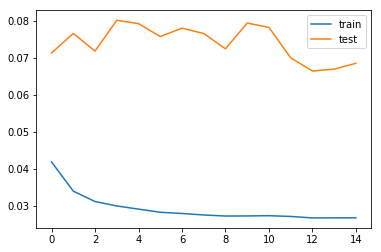

In [22]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#Copying test data
test_C=test_X

In [23]:
test_X=test_C
#yhat = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
#print(test_X)

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

inv_yhat=model.predict(test_X)
for i in range(len(inv_yhat)):
    inv_yhat[i]=inv_yhat[i]*5000
#print(inv_yhat)

# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

inv_y=test_y
for i in range(len(inv_y)):
    inv_y[i]=inv_y[i]*5000
#print(inv_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 421.397


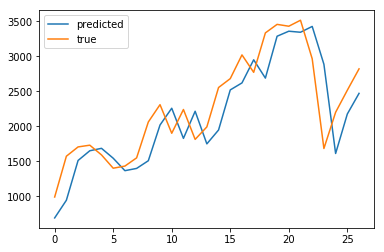

In [24]:
# plot history
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

In [25]:
#Configuring Watson Machine Learning
wml_credentials = {
  "apikey": "Eo8pRodW8h_4DGsrSkzUoiwmugUPAgzG26I9Kbwh6gCq",
  "iam_apikey_description": "Auto-generated for key 794c96fc-d7e8-4417-b6f6-a3417f71fa13",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/92edfba906944295822469763713aa19::serviceid:ServiceId-f186b61a-a5d5-46ec-b039-2a8df6e74a18",
  "instance_id": "e09aa387-d889-40c9-bb62-1691da89477b",
  "url": "https://us-south.ml.cloud.ibm.com"
}
client = WatsonMachineLearningAPIClient( wml_credentials )

In [27]:
#STORING MODEL
metadata = {
    client.repository.ModelMetaNames.NAME: "WindBot",
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.15",
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': '2.2.5'}]}
model_details = client.repository.store_model( model="WindBot.tgz", meta_props=metadata )
print(model_details)

{'metadata': {'guid': '52aed15c-9c43-4a46-a0b0-0f3bcddc24c2', 'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e09aa387-d889-40c9-bb62-1691da89477b/published_models/52aed15c-9c43-4a46-a0b0-0f3bcddc24c2', 'created_at': '2020-06-29T03:41:01.195Z', 'modified_at': '2020-06-29T03:41:01.253Z'}, 'entity': {'runtime_environment': 'None Provided', 'learning_configuration_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e09aa387-d889-40c9-bb62-1691da89477b/published_models/52aed15c-9c43-4a46-a0b0-0f3bcddc24c2/learning_configuration', 'name': 'WindBot', 'learning_iterations_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e09aa387-d889-40c9-bb62-1691da89477b/published_models/52aed15c-9c43-4a46-a0b0-0f3bcddc24c2/learning_iterations', 'feedback_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e09aa387-d889-40c9-bb62-1691da89477b/published_models/52aed15c-9c43-4a46-a0b0-0f3bcddc24c2/feedback', 'latest_version': {'url': 'https://us-south.ml.cloud.ibm.com/v3/ml_ass

In [28]:
#DEPLOYING MODEL
#model_id = model_details["metadata"]["guid"]
model_id='52aed15c-9c43-4a46-a0b0-0f3bcddc24c2'
deployment_details = client.deployments.create( artifact_uid=model_id, name="WindBot" )
print(deployment_details)



#######################################################################################

Synchronous deployment creation for uid: '52aed15c-9c43-4a46-a0b0-0f3bcddc24c2' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS..
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='2008c125-3a70-4909-964c-d5b227dc57d0'
------------------------------------------------------------------------------------------------


{'metadata': {'guid': '2008c125-3a70-4909-964c-d5b227dc57d0', 'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e09aa387-d889-40c9-bb62-1691da89477b/deployments/2008c125-3a70-4909-964c-d5b227dc57d0', 'created_at': '2020-06-29T03:41:21.294Z', 'modified_at': '2020-06-29T03:41:22.131Z'}, 'entity': {'runtime_environment': 'None Provided', 'name': 'WindBot', 'scoring_url': 'https

In [29]:
#Getting result from deployed model
test_X=test_C
deployment_details={'metadata': {'guid': '2008c125-3a70-4909-964c-d5b227dc57d0', 'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e09aa387-d889-40c9-bb62-1691da89477b/deployments/2008c125-3a70-4909-964c-d5b227dc57d0', 'created_at': '2020-06-29T03:41:21.294Z', 'modified_at': '2020-06-29T03:41:22.131Z'}, 'entity': {'runtime_environment': 'None Provided', 'name': 'WindBot', 'scoring_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e09aa387-d889-40c9-bb62-1691da89477b/deployments/2008c125-3a70-4909-964c-d5b227dc57d0/online', 'deployable_asset': {'name': 'WindBot', 'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e09aa387-d889-40c9-bb62-1691da89477b/published_models/52aed15c-9c43-4a46-a0b0-0f3bcddc24c2', 'guid': '52aed15c-9c43-4a46-a0b0-0f3bcddc24c2', 'created_at': '2020-06-29T03:41:21.266Z', 'type': 'model'}, 'description': 'Description of deployment', 'status_details': {'status': 'DEPLOY_SUCCESS'}, 'model_type': 'tensorflow-1.15', 'status': 'DEPLOY_SUCCESS', 'type': 'online', 'deployed_version': {'url': 'https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/52aed15c-9c43-4a46-a0b0-0f3bcddc24c2/versions/0c694d34-93d3-407b-ae95-80dbef140b51', 'guid': '0c694d34-93d3-407b-ae95-80dbef140b51'}}}
model_endpoint_url = client.deployments.get_scoring_url( deployment_details )
payload = { "values" : test_X.tolist() }
data=client.deployments.score( model_endpoint_url, payload )

In [35]:
#print(data['values'])

yhat=[]

for i in data['values']:
    yhat.append(i[0])

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

inv_yhat=model.predict(test_X)
for i in range(len(inv_yhat)):
    inv_yhat[i]=inv_yhat[i]*5000
#print(inv_yhat)

# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

inv_y=test_y
for i in range(len(inv_y)):
    inv_y[i]=inv_y[i]*5000
#print(inv_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 421.397


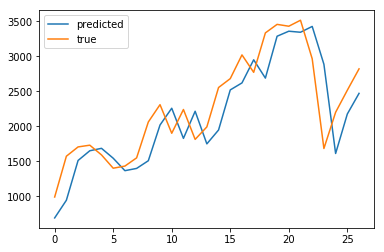

In [36]:
# plot history
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()